In [1]:
# General Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Neural Network Libraries (PyTorch)
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Neural Network Libraries (Keras for LSTM)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Word Cloud
from wordcloud import WordCloud

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download necessary NLTK data packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [3]:
# Define the path to the dataset
DATA_PATH = '/kaggle/input/fake-news-detection-using-machine-learning/'

# Paths to the CSV files
true_csv = os.path.join(DATA_PATH, 'True.csv')
fake_csv = os.path.join(DATA_PATH, 'Fake.csv')

# Check if files exist
if not os.path.exists(true_csv) or not os.path.exists(fake_csv):
    raise FileNotFoundError("True.csv or Fake.csv not found in the specified directory.")

# Load true news
true_df = pd.read_csv(true_csv)
true_df['label'] = 1  # Label true news as 1

# Load fake news
fake_df = pd.read_csv(fake_csv)
fake_df['label'] = 0  # Label fake news as 0

# Combine datasets
data_df = pd.concat([true_df, fake_df], axis=0).reset_index(drop=True)

# Display the first few rows
print("Combined Dataset Sample:")
print(data_df.head())

Combined Dataset Sample:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1  


In [4]:
# Remove duplicates
initial_shape = data_df.shape
data_df.drop_duplicates(inplace=True)
print(f"Removed {initial_shape[0] - data_df.shape[0]} duplicate rows.")

# Remove missing values
initial_shape = data_df.shape
data_df.dropna(inplace=True)
print(f"Removed {initial_shape[0] - data_df.shape[0]} rows with missing values.")

# Reset index after dropping
data_df.reset_index(drop=True, inplace=True)

Removed 209 duplicate rows.
Removed 0 rows with missing values.


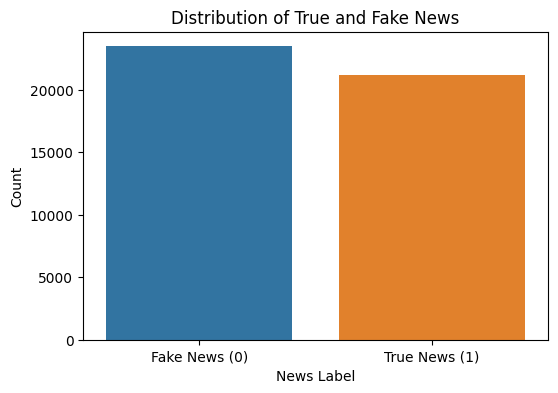

In [5]:
# Distribution of labels
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data_df)
plt.title('Distribution of True and Fake News')
plt.xticks([0,1], ['Fake News (0)', 'True News (1)'])
plt.xlabel('News Label')
plt.ylabel('Count')
plt.show()

In [6]:
# Initialize SnowballStemmer
stemmer = SnowballStemmer("english")

# Define stopwords
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    # Convert to lowercase
    text = text.lower()
    # Remove URLs and email addresses
    text = re.sub(r'http\S+|www\S+|https\S+|[\w\.-]+@[\w\.-]+', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = text.strip()
    # Remove stopwords and perform stemming
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    # Rejoin words
    text = ' '.join(tokens)
    return text

# Combine title and text, then preprocess
data_df['text_clean'] = data_df['title'] + ' ' + data_df['text']
data_df['text_clean'] = data_df['text_clean'].apply(text_preprocessing)

# Display the cleaned text
print("\nSample of Cleaned Text:")
print(data_df[['title', 'text', 'text_clean', 'label']].head())


Sample of Cleaned Text:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text  \
0  WASHINGTON (Reuters) - The head of a conservat...   
1  WASHINGTON (Reuters) - Transgender people will...   
2  WASHINGTON (Reuters) - The special counsel inv...   
3  WASHINGTON (Reuters) - Trump campaign adviser ...   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...   

                                          text_clean  label  
0  us budget fight loom republican flip fiscal sc...      1  
1  us militari accept transgend recruit monday pe...      1  
2  senior us republican senat let mr mueller job ...      1  
3  fbi russia probe help australian diplomat tipo... 

In [7]:
# Features and labels
X = data_df['text_clean']
y = data_df['label']

# Split the data into training and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining Set Size: {X_train.shape[0]} samples")
print(f"Test Set Size: {X_test.shape[0]} samples")


Training Set Size: 35751 samples
Test Set Size: 8938 samples


In [8]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, transform the test data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"\nTF-IDF Vectorization Complete. Number of Features: {X_train_tfidf.shape[1]}")


TF-IDF Vectorization Complete. Number of Features: 5000


In [9]:
# Feature Selection using Logistic Regression Coefficients
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

# Get feature names and their coefficients
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = lr.coef_[0]

# Top 10 features indicative of True News
top_positive_indices = coefficients.argsort()[-10:]
print("\nTop 10 words indicative of True News:")
for index in top_positive_indices:
    print(f"{feature_names[index]}: {coefficients[index]:.4f}")

# Top 10 features indicative of Fake News
top_negative_indices = coefficients.argsort()[:10]
print("\nTop 10 words indicative of Fake News:")
for index in top_negative_indices:
    print(f"{feature_names[index]}: {coefficients[index]:.4f}")


Top 10 words indicative of True News:
thursday: 4.4915
us: 4.5593
tuesday: 4.8302
wednesday: 5.1662
washington: 5.2098
the: 5.6371
it: 5.6822
we: 6.0580
said: 17.3235
reuter: 24.7621

Top 10 words indicative of Fake News:
video: -9.3009
via: -8.1462
imag: -6.8222
hillari: -5.3830
gop: -5.2385
wire: -4.5927
american: -4.3855
america: -4.2803
mr: -4.2738
obama: -4.1589


In [10]:
# Initialize the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Cross-validation
nb_cv_scores = cross_val_score(nb_classifier, X_train_tfidf, y_train, cv=5)
print(f"\nNaive Bayes Cross-Validation Accuracy: {nb_cv_scores.mean():.4f} ± {nb_cv_scores.std():.4f}")

# Train the model
nb_classifier.fit(X_train_tfidf, y_train)


Naive Bayes Cross-Validation Accuracy: 0.9344 ± 0.0029


MultinomialNB()

In [11]:
# Initialize the Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000)

# Cross-validation
lr_cv_scores = cross_val_score(lr_classifier, X_train_tfidf, y_train, cv=5)
print(f"Logistic Regression Cross-Validation Accuracy: {lr_cv_scores.mean():.4f} ± {lr_cv_scores.std():.4f}")

# Train the model
lr_classifier.fit(X_train_tfidf, y_train)

Logistic Regression Cross-Validation Accuracy: 0.9875 ± 0.0021


LogisticRegression(max_iter=1000)

In [12]:
# Convert data to tensors
X_train_tensor = torch.tensor(X_train_tfidf.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_tfidf.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network
class NewsClassifier(nn.Module):
    def __init__(self, input_size):
        super(NewsClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 2)  # Output layer for binary classification

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Initialize the model
input_size = X_train_tfidf.shape[1]
model_pytorch = NewsClassifier(input_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pytorch.parameters(), lr=0.001)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    epoch_loss = 0
    model_pytorch.train()
    for texts, labels in train_loader:
        # Forward pass
        outputs = model_pytorch(texts)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/5], Loss: 0.0758
Epoch [2/5], Loss: 0.0101
Epoch [3/5], Loss: 0.0035
Epoch [4/5], Loss: 0.0037
Epoch [5/5], Loss: 0.0051


In [13]:
# Define parameters for Tokenizer and padding
MAX_NUM_WORDS = 5000  # Vocabulary size
MAX_SEQUENCE_LENGTH = 500  # Maximum sequence length

# Initialize Tokenizer
tokenizer_lstm = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer_lstm.fit_on_texts(X_train)

# Convert texts to sequences
X_train_sequences = tokenizer_lstm.texts_to_sequences(X_train)
X_test_sequences = tokenizer_lstm.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"\nPadded Training Data Shape: {X_train_padded.shape}")
print(f"Padded Test Data Shape: {X_test_padded.shape}")

# Define LSTM model architecture
model_lstm = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Display model summary
model_lstm.summary()

# Train the model with Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_lstm.fit(
    X_train_padded,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)


Padded Training Data Shape: (35751, 500)
Padded Test Data Shape: (8938, 500)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
447/447 - 336s - 751ms/step - accuracy: 0.5374 - loss: 0.6885 - val_accuracy: 0.5531 - val_loss: 0.6723
Epoch 2/10
447/447 - 331s - 740ms/step - accuracy: 0.5545 - loss: 0.6695 - val_accuracy: 0.5552 - val_loss: 0.6640
Epoch 3/10
447/447 - 332s - 742ms/step - accuracy: 0.7256 - loss: 0.5099 - val_accuracy: 0.8586 - val_loss: 0.3545
Epoch 4/10
447/447 - 332s - 742ms/step - accuracy: 0.9272 - loss: 0.2031 - val_accuracy: 0.9750 - val_loss: 0.0768
Epoch 5/10
447/447 - 330s - 739ms/step - accuracy: 0.9724 - loss: 0.0836 - val_accuracy: 0.9761 - val_loss: 0.0885
Epoch 6/10
447/447 - 333s - 744ms/step - accuracy: 0.9846 - loss: 0.0538 - val_accuracy: 0.9890 - val_loss: 0.0346
Epoch 7/10
447/447 - 333s - 745ms/step - accuracy: 0.9933 - loss: 0.0262 - val_accuracy: 0.9919 - val_loss: 0.0254
Epoch 8/10
447/447 - 332s - 743ms/step - accuracy: 0.9965 - loss: 0.0126 - val_accuracy: 0.9937 - val_loss: 0.0200
Epoch 9/10
447/447 - 382s - 855ms/step - accuracy: 0.9976 - loss: 0.0093 - val_a


Naive Bayes Classifier Metrics:
Accuracy: 0.9340
Precision: 0.9298
Recall: 0.9312
F1 Score: 0.9305


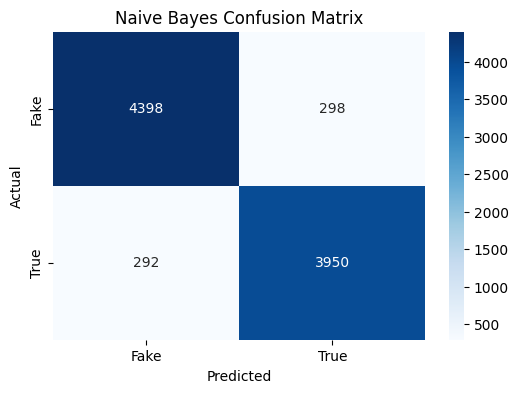

In [14]:
# Predictions
nb_predictions = nb_classifier.predict(X_test_tfidf)

# Evaluation
print("\nNaive Bayes Classifier Metrics:")
print(f"Accuracy: {accuracy_score(y_test, nb_predictions):.4f}")
print(f"Precision: {precision_score(y_test, nb_predictions):.4f}")
print(f"Recall: {recall_score(y_test, nb_predictions):.4f}")
print(f"F1 Score: {f1_score(y_test, nb_predictions):.4f}")

# Confusion Matrix
nb_cm = confusion_matrix(y_test, nb_predictions)
plt.figure(figsize=(6,4))
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Logistic Regression Classifier Metrics:
Accuracy: 0.9887
Precision: 0.9841
Recall: 0.9922
F1 Score: 0.9881


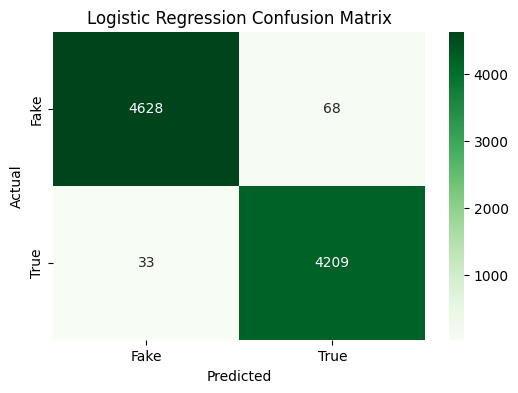

In [15]:
# Predictions
lr_predictions = lr_classifier.predict(X_test_tfidf)

# Evaluation
print("\nLogistic Regression Classifier Metrics:")
print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(f"Precision: {precision_score(y_test, lr_predictions):.4f}")
print(f"Recall: {recall_score(y_test, lr_predictions):.4f}")
print(f"F1 Score: {f1_score(y_test, lr_predictions):.4f}")

# Confusion Matrix
lr_cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(6,4))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Neural Network (PyTorch) Classifier Metrics:
Accuracy: 0.9893
Precision: 0.9862
Recall: 0.9913
F1 Score: 0.9887


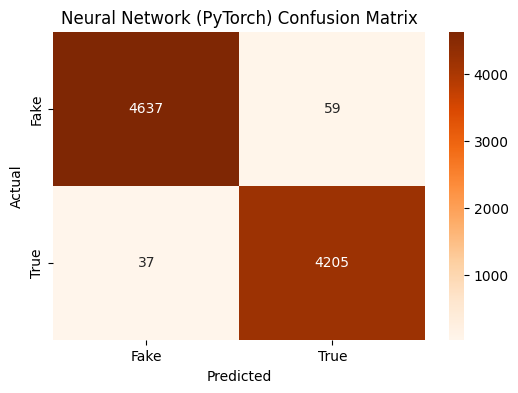

In [16]:
# Switch model to evaluation mode
model_pytorch.eval()

# No gradient calculation needed
with torch.no_grad():
    outputs = model_pytorch(X_test_tensor)
    _, nn_predictions = torch.max(outputs, 1)

# Evaluation
print("\nNeural Network (PyTorch) Classifier Metrics:")
print(f"Accuracy: {accuracy_score(y_test_tensor, nn_predictions):.4f}")
print(f"Precision: {precision_score(y_test_tensor, nn_predictions):.4f}")
print(f"Recall: {recall_score(y_test_tensor, nn_predictions):.4f}")
print(f"F1 Score: {f1_score(y_test_tensor, nn_predictions):.4f}")

# Confusion Matrix
nn_cm = confusion_matrix(y_test_tensor, nn_predictions)
plt.figure(figsize=(6,4))
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Neural Network (PyTorch) Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

280/280 ━━━━━━━━━━━━━━━━━━━━ 54s 191ms/step

LSTM Model Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4242

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



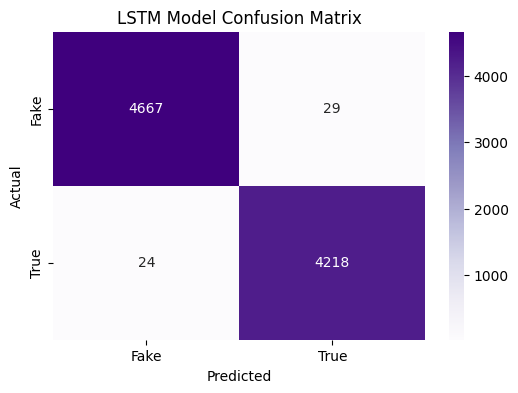

In [17]:
# Predictions probabilities
y_pred_probs_lstm = model_lstm.predict(X_test_padded).flatten()

# Convert probabilities to binary predictions (default threshold 0.5)
y_pred_lstm = (y_pred_probs_lstm >= 0.5).astype(int)

# Classification Report
print("\nLSTM Model Classification Report:")
print(classification_report(y_test, y_pred_lstm))

# Confusion Matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(6,4))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Purples', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('LSTM Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))

print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions))

print("Neural Network (PyTorch) Classification Report:")
print(classification_report(y_test_tensor, nn_predictions))

print("LSTM Model Classification Report:")
print(classification_report(y_test, y_pred_lstm))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4696
           1       0.93      0.93      0.93      4242

    accuracy                           0.93      8938
   macro avg       0.93      0.93      0.93      8938
weighted avg       0.93      0.93      0.93      8938

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.98      0.99      0.99      4242

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938

Neural Network (PyTorch) Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4242

    accuracy                           0.99      8938
 


Best parameters found for Logistic Regression: {'C': 10, 'max_iter': 1000, 'solver': 'liblinear'}

Optimized Logistic Regression Metrics:
Accuracy: 0.9943
Precision: 0.9927
Recall: 0.9953
F1 Score: 0.9940


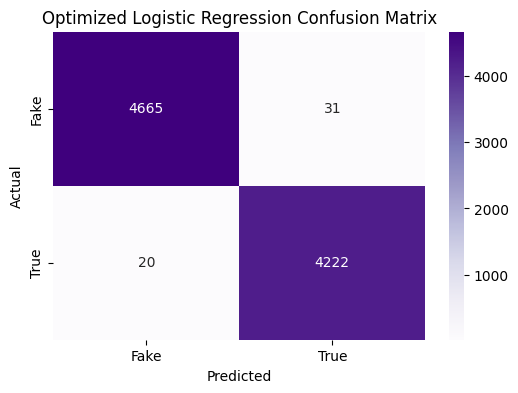

In [19]:
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [1000]
}

# Grid Search with Cross-Validation
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_tfidf, y_train)

# Best parameters
print(f"\nBest parameters found for Logistic Regression: {grid_search.best_params_}")

# Best estimator
best_lr_model = grid_search.best_estimator_

# Evaluate the best model
best_lr_predictions = best_lr_model.predict(X_test_tfidf)

print("\nOptimized Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, best_lr_predictions):.4f}")
print(f"Precision: {precision_score(y_test, best_lr_predictions):.4f}")
print(f"Recall: {recall_score(y_test, best_lr_predictions):.4f}")
print(f"F1 Score: {f1_score(y_test, best_lr_predictions):.4f}")

# Confusion Matrix
best_lr_cm = confusion_matrix(y_test, best_lr_predictions)
plt.figure(figsize=(6,4))
sns.heatmap(best_lr_cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Optimized Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Ensemble Classifier Metrics:
Accuracy: 0.9867
Precision: 0.9824
Recall: 0.9896
F1 Score: 0.9860


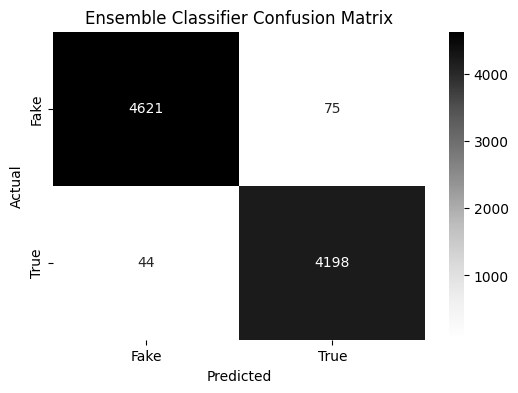

In [20]:
from sklearn.ensemble import VotingClassifier

# Create ensemble of classifiers
ensemble_classifier = VotingClassifier(
    estimators=[
        ('nb', nb_classifier),
        ('lr', best_lr_model)
    ],
    voting='soft'  # 'hard' voting can also be used
)

# Train ensemble
ensemble_classifier.fit(X_train_tfidf, y_train)

# Predictions
ensemble_predictions = ensemble_classifier.predict(X_test_tfidf)

# Evaluation
print("\nEnsemble Classifier Metrics:")
print(f"Accuracy: {accuracy_score(y_test, ensemble_predictions):.4f}")
print(f"Precision: {precision_score(y_test, ensemble_predictions):.4f}")
print(f"Recall: {recall_score(y_test, ensemble_predictions):.4f}")
print(f"F1 Score: {f1_score(y_test, ensemble_predictions):.4f}")

# Confusion Matrix
ensemble_cm = confusion_matrix(y_test, ensemble_predictions)
plt.figure(figsize=(6,4))
sns.heatmap(ensemble_cm, annot=True, fmt='d', cmap='Greys', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.title('Ensemble Classifier Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()